# Wyjaśnialne Uczenie Maszynowe - Praca domowa nr 9
### Wojciech Celej

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook as tqdm

## 1. Załadowanie danych

### Electricity market dataset

Oryginalny opis zbioru:

This problem is often used as a benchmark for concept drift classification. Initially described by Harris et al. it was used thereafter for several performance comparisons. A critical note to its suitability as a benchmark can be found in. The dataset holds information of the Australian New South Wales Electricity Market, whose prices are affected by supply and demand. Each sample, characterized by attributes such as day of week, time stamp, market demand etc., refers to a period of 30 minutes and the class label identifies the relative change (higher or lower) compared to the last 24 hours. We used the normalized version as it also can be found here.

We used the normalized version as it can be found on moa http://moa.cms.waikato.ac.nz/datasets/  
However, we always remove the "date" and "nswprice" as suggested by Gamma et al. from the data before learning. Hence, the used features are the following:  
day:	1,2,3,4,5,6,7.  
period:	continuous.  
nswdemand:	continuous.  
vicprice:	continuous.  
vicdemand:	continuous.  
transfer:	continuous.  

In [2]:
X = pd.read_csv("elec2_data.dat", header=None, sep=" ")
X.columns = ["date", "day", "period", "nswsprice", "nswdemand", "vicprice", "vicdemand", "transfer"]
X = X[X.columns.difference(["date", "nswsprice"])]
y = pd.read_csv("elec2_label.dat", header=None).iloc[:,0]

## 2. Budowa modeli na pierwszych 10% i ostatnich 10% zbioru. Rozkłady zmiennych, odległości pomiędzy odpowiedziami modelu na obu zbiorach danych

### Podział zbioru

Wybrano 10% obserwacji z początku oryginalnego zbioru danych oraz 10% z kónca. Określane dalej będą `Head`, `Tail`.

In [3]:
X_head = X.head(int(X.shape[0]*0.1))
y_head = y.head(int(y.shape[0]*0.1))

X_tail = X.tail(int(X.shape[0]*0.1))
y_tail = y.tail(int(y.shape[0]*0.1))

In [4]:
X_head.describe()

,day,nswdemand,period,transfer,vicdemand,vicprice
count,4531.000000,4531.000000,4531.000000,4531.000000,4.531000e+03,4531.000000
mean,3.972412,0.469084,0.498706,0.414912,4.229150e-01,0.003467
std,1.978223,0.160941,0.294938,0.000000,5.551728e-17,0.000000
min,1.000000,0.052812,0.000000,0.414912,4.229150e-01,0.003467
25%,2.000000,0.360235,0.234043,0.414912,4.229150e-01,0.003467
50%,4.000000,0.495686,0.489362,0.414912,4.229150e-01,0.003467
75%,6.000000,0.578697,0.744681,0.414912,4.229150e-01,0.003467
max,7.000000,0.922642,1.000000,0.414912,4.229150e-01,0.003467


In [5]:
X_tail.describe()

,day,nswdemand,period,transfer,vicdemand,vicprice
count,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000,4531.000000
mean,4.063562,0.395717,0.501294,0.508560,0.422547,0.004327
std,2.000314,0.129710,0.294938,0.153089,0.144698,0.007487
min,1.000000,0.057126,0.000000,0.047807,0.030295,0.001037
25%,2.000000,0.314638,0.255319,0.393860,0.304764,0.002887
50%,4.000000,0.429337,0.510638,0.500439,0.420766,0.003540
75%,6.000000,0.494942,0.765957,0.625220,0.547514,0.005468
max,7.000000,0.663047,1.000000,0.923684,0.915070,0.358386


### Rozkłady zmiennych w podzielonych zbiorach

Wykresy poniżej przedstawiają rozkład zmiennych w ramach wybranych zbiorów.

In [6]:
def plot_histograms(original_df, df1, df2, num_of_bins=20, figs_in_row=2):
    assert (original_df.columns == df1.columns).all
    assert (df1.columns == df2.columns).all and df1.shape == df2.shape
    sns.set(rc={'figure.figsize':(16,16)})
    sns.set_style('whitegrid')
    sns.set_palette("Set1")
    figs_in_col = int(np.ceil(len(original_df.columns)/figs_in_row))
    for i, feature in enumerate(original_df.columns):
        xrange = (original_df[feature].min(), original_df[feature].max())
        plt.subplot(figs_in_col, figs_in_row, i+1)
        ax1 = sns.distplot(df1[feature], bins=num_of_bins, norm_hist=True, hist_kws={"alpha": 0.6}, label="Head")
        ax2 = sns.distplot(df2[feature], bins=num_of_bins, norm_hist=True, hist_kws={"alpha": 0.6}, label="Tail")
        plt.xlabel("")
        plt.title(feature)
        y_lim1 = ax1.get_ylim()
        y_lim2 = ax2.get_ylim()
        plt.ylim(np.minimum(y_lim1[0], y_lim2[0]), np.maximum(y_lim1[1], y_lim2[1]))
        plt.xlim(xrange[0], xrange[1])
    plt.legend(prop={'size': 14})
    plt.show()

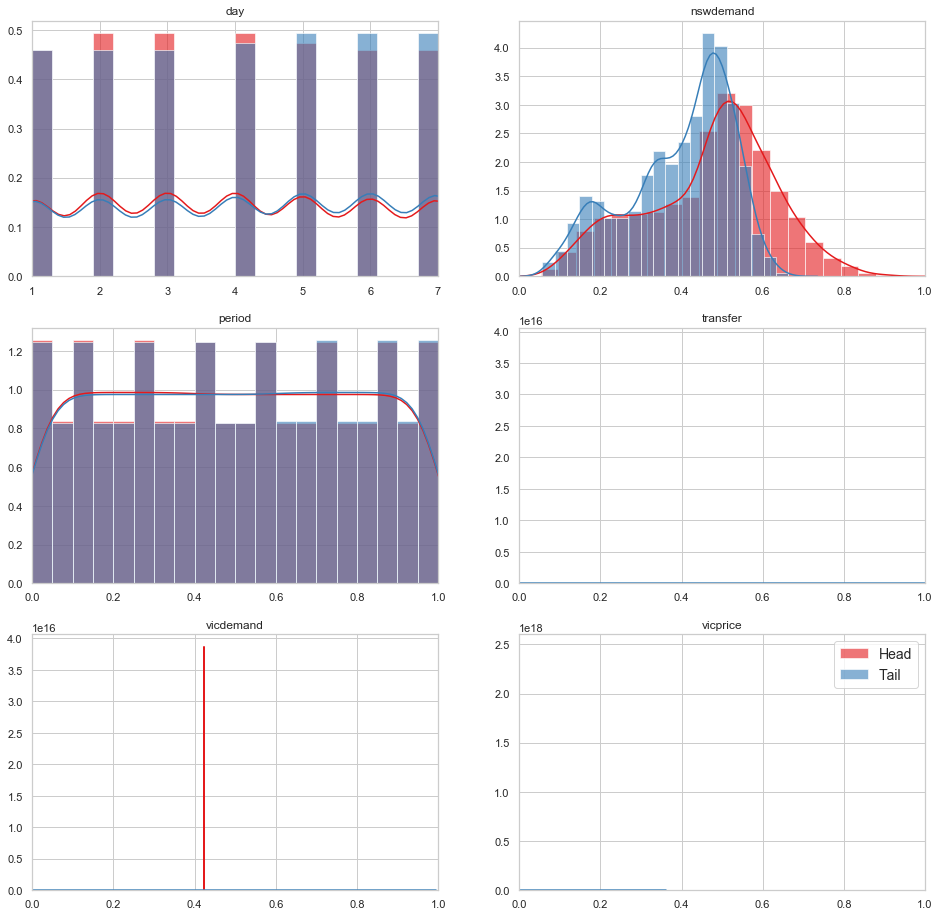

In [7]:
plot_histograms(X, X_head, X_tail)

Rozkłady zmiennych `day`, `period` i `icprice` nie odbiegają od siebie znacząco, w przypadku pozostałych zmiennych można zauważyć różnice. Wielkość tych różnic zostanie zmierzona w rozdz. 3.

### Budowa modeli na podzielonych zbiorach

Dla obu modeli zbudowano model regresji logistycznej.

In [8]:
X_train_head, X_test_head, y_train_head, y_test_head = train_test_split(X_head, y_head, test_size=0.1)

model_head = LogisticRegression(solver="liblinear")
model_head.fit(X_train_head, y_train_head)
y_pred_head = model_head.predict_proba(X_test_head)[:, 1]

X_train_tail, X_test_tail, y_train_tail, y_test_tail = train_test_split(X_tail, y_tail, test_size=0.1)

model_tail = LogisticRegression(solver="liblinear")
model_tail.fit(X_train_tail, y_train_tail)
y_pred_tail = model_tail.predict_proba(X_test_tail)[:, 1]

### Intersection distances - odpowiedzi modelu

Dwie wartości skrajne `intersection distance` oznaczają:
* 0 - jeśli dwa histogramy są identyczne
* 1 - jeśli dwa histogramy są różne

In [9]:
def intersection_distance(data1, data2, x_range, num_of_bins):
    assert data1.shape == data2.shape
    num_of_samples = data1.shape[0]
    hist1 = np.histogram(data1, range=x_range, bins=num_of_bins)[0]/num_of_samples
    hist2 = np.histogram(data2, range=x_range, bins=num_of_bins)[0]/num_of_samples
    intersection_distances = []
    for i in range(len(hist1)):
        intersection_distances.append(np.minimum(hist1[i], hist2[i]))
    cum_intersection_distance = 1 - np.sum(intersection_distances)
    return cum_intersection_distance

Wykres poniżej przedstawia rozkład wartości predykcji dla zbioru `Head` i zbioru `Tail`. Predykcji dokonywano na odpowiadających im modelach.

In [10]:
def plot_intersectioon_distances_for_preds(y_pred1, y_pred2, num_of_bins=20):
    intersection_dist = intersection_distance(y_pred1, y_pred2, (0, 1), num_of_bins)
    sns.set(rc={'figure.figsize':(12,7)})
    sns.set_style("whitegrid")
    sns.set_palette("Set1")
    sns.distplot(y_pred1, bins=num_of_bins, norm_hist=True, hist_kws={"alpha": 0.6}, label="Head")
    sns.distplot(y_pred2, bins=num_of_bins, norm_hist=True, hist_kws={"alpha": 0.6}, label="Tail")
    plt.title(f"Intersection distance for predictions = {intersection_dist: .3f}", size=16)
    plt.legend(prop={'size': 14})
    plt.show()

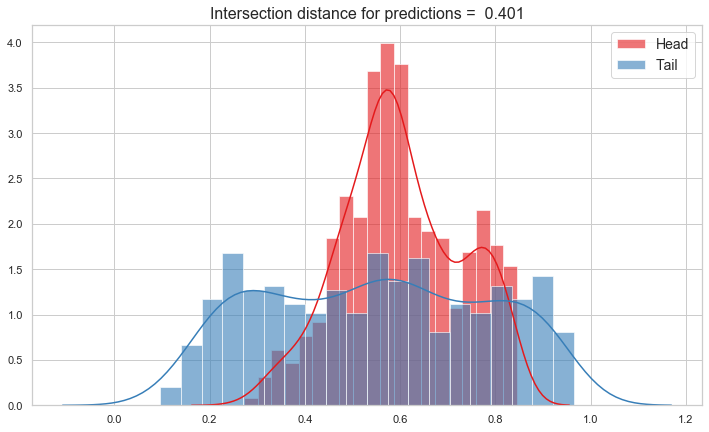

In [11]:
plot_intersectioon_distances_for_preds(y_pred_head, y_pred_tail)

Wyznaczona wartość `intersection distance` oznacza, że wartości predykcji różnią się od siebie dla dwóch krańców wyjściowego zbioru. 

## 3. Intersection distance dla każdej zmiennej ze zbioru danych. Intersection distance dla reszt z obu modeli. Pole pomiędzy krzywymi PDP

### Intersection distances - features

Wykres poniżej przedstawia wartości `intersection distance` dla rozkładu zmiennych dla zbiorów `Head` i `Tail`.

In [12]:
def plot_intesection_distances_for_variables(original_df, df1, df2, num_of_bins=50):
    assert (original_df.columns == df1.columns).all
    assert (df1.columns == df2.columns).all 
    assert df1.shape == df2.shape
    intersection_distances = {}
    for feature in original_df.columns:
        x_range = (original_df[feature].min(), original_df[feature].max())
        intersection_distances[feature] = intersection_distance(df1[feature], df2[feature], x_range, num_of_bins)

    plot_data = pd.DataFrame({"feature": list(intersection_distances.keys()), "value": list(intersection_distances.values())})
    sns.set(rc={'figure.figsize':(10,7)})
    sns.set_style('whitegrid')
    sns.set_palette("Set1")
    sns.barplot(data = plot_data, x="feature", y="value", color="steelblue")
    plt.title("Intersection distances for features", size=16)
    plt.show()

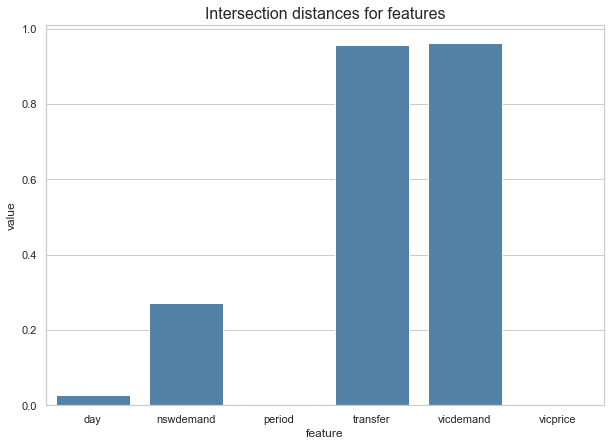

In [13]:
plot_intesection_distances_for_variables(X, X_head, X_tail)

Stwierdzić można, że rozkłady 3 zmiennych na krańcach oryginalnego zbioru są zdecydowanie od siebie różne, co jest anomalią typu *variable drift*.

### Intersection distances - residuals

Wykres poniżej przedstawia rozkład residuuów dla zbiorów testowych wyodrębnionych odpowiednio z `Head` i `Tail`. Predykcji w ramach obu zbiorów testowych dokonano dla modelu regresji logistycznej wytrenowanego na zbiorze treningowym z `Head`.

In [14]:
def plot_intersectioon_distances_for_residuals(model, X_test1, X_test2, y_test1, y_test2, num_of_bins=20):
    residuals1 = y_test1 - model.predict_proba(X_test1)[:, 1]
    residuals2 = y_test2 - model.predict_proba(X_test2)[:, 1]
    intersection_dist = intersection_distance(residuals1, residuals2, (0, 1), num_of_bins)
    sns.set(rc={'figure.figsize':(12,7)})
    sns.set_style("whitegrid")
    sns.set_palette("Set1")
    sns.distplot(residuals1, bins=num_of_bins, norm_hist=True, hist_kws={"alpha": 0.6}, label="Head")
    sns.distplot(residuals2, bins=num_of_bins, norm_hist=True, hist_kws={"alpha": 0.6}, label="Tail")
    plt.title(f"Intersection distance for residuals = {intersection_dist: .3f}", size=16)
    plt.legend(prop={'size': 14})
    plt.show()

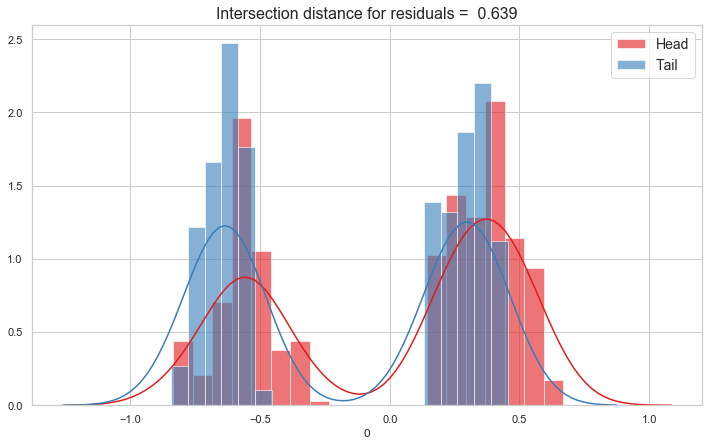

In [15]:
plot_intersectioon_distances_for_residuals(model_head, X_test_head, X_test_tail, y_test_head, y_test_tail)

Zauważyć można, że rozkład residuuów dla `Tail` jest przesunięty w prawo względem `Head`. Wartosć `intersection distance` powyżej 0.6 oznacza, że rozkłądy residuuów różnią się od siebie znacząco. Jest to anomalia typu *residuals drift*.

### Odległości pomiędzy krzywymi PDP

In [16]:
def calculate_pdp_values(model, df, feature, nPoints, featureRange):
    x = np.linspace(featureRange[0], featureRange[1], num=nPoints, endpoint=True)
    y_cum = []
    df_columns = df.columns
    for row_index in range(df.shape[0]):
        sample = pd.DataFrame(columns=df_columns)
        sample.loc[0] = df.iloc[row_index, :]
        samples = sample.append([sample.iloc[0, :]]*(nPoints-1), ignore_index=True).reset_index(drop=True)
        samples.loc[:, feature] = x
        y = model.predict_proba(samples)[:, 1]
        y_cum.append(y)
    y_cum = np.array(y_cum).mean(axis=0)
    return x, y_cum

In [17]:
def compare_pdp(original_df, feature, model1, model2, X_train1, X_train2, num_of_points=100):
    x_range = (original_df[feature].min(), original_df[feature].max())
    x, pdp1 = calculate_pdp_values(model1, X_train1, feature, num_of_points, x_range)
    x, pdp2 = calculate_pdp_values(model2, X_train2, feature, num_of_points, x_range)
    sns.lineplot(x, pdp1, linewidth=4, label="Head")
    sns.lineplot(x, pdp2, linewidth=4, label="Tail")
    plt.fill_between(x, pdp1, pdp2, color="lightgrey", alpha=0.5)
    integral = np.trapz(abs(pdp1 - pdp2), x)
    plt.title(feature)
    plt.ylim(0, 1)
    plt.xlabel(f"Area between PDP = {integral:0.3f}")

Wykresy poniżej prezentują porównanie krzywych PDP dla zmiennych w zbiorach testowych `Head` i `Tail`. Wyliczono też pole pomiędzy krzywymi PDP.

In [18]:
def plot_pdp_compare_for_feature(model1, model2, original_df, df1, df2, figs_in_row=2):
    assert (original_df.columns == df1.columns).all
    assert (df1.columns == df2.columns).all and df1.shape == df2.shape
    sns.set(rc={'figure.figsize':(16,16)})
    sns.set_style('whitegrid')
    sns.set_palette("Set1")
    plt.subplots_adjust(hspace=0.4)
    figs_in_col = int(np.ceil(len(original_df.columns)/figs_in_row))
    for i, feature in enumerate(original_df.columns):
        plt.subplot(figs_in_col, figs_in_row, i+1)
        compare_pdp(original_df, feature, model1, model2, df1, df2)
    plt.legend(prop={'size': 14})
    plt.show()

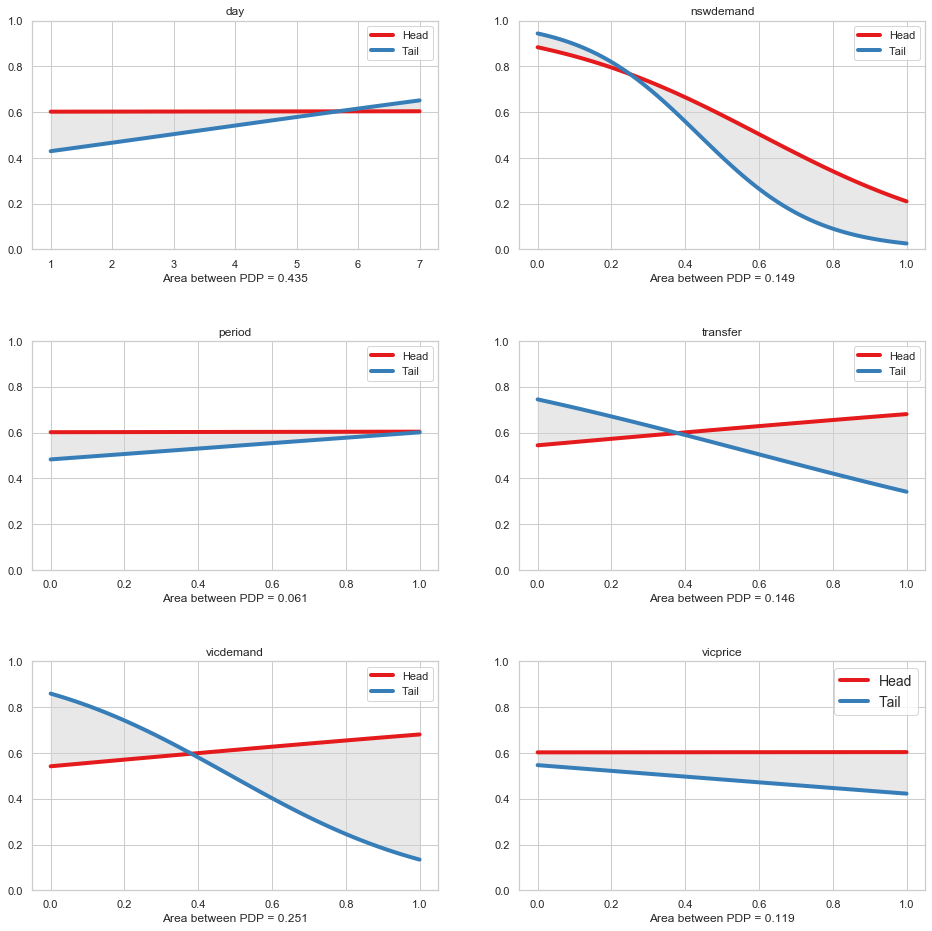

In [19]:
plot_pdp_compare_for_feature(model_head, model_tail, X, X_test_head, X_test_tail)

Dla wszystkich zmiennych można zaobserwować różnice w interpretacji zmiennych, szczególnie jednak dla zmiennych `transfer` i `vicdemand` krzywe PDP mają odmienne tendencje. Również te 2 zmienne wykazały anomalię typu *variable drift*. Stwierdzić można dla tych zmiennych także anomalię typu *concept drift*.

## 4. Wnioski

* Powyższy zbiór przeznaczony jest do wykrywania anomalii typu *drift*. Są to dane prawdziwe i dotyczą sprzedaży w sklepach elektronicznych.
* Naiwne podejście do budowy modelu może prowadzić do blędnych wyników, wniosków, niezrozumienia problemu. Konieczne jest wykrycie anomalii i ich korekta z wykorzystaniem wiedzy eksperckiej.
* W modelu powyżej przewidywano wzrost/spadek ceny w przeciągu 30 minut, w odniesieniu do ostatnich 24 godzin. To co powoduje *dryfowanie*, to fakt, że dane osadzone są w czasie (szereg czasowy) i w różnych okresach obowiązuje odmienny popyt i podaż na rynku.